In [1]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

from mamba_lens import HookedMamba # this will take a little while to import

model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [2]:
# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 50
seed = 27
valid_seed = 28
constrain_to_answers = True
has_symmetric_patching = True

templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())

data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)

names ['Aaron', 'Abraham', 'Adam', 'Adrian', 'Alan', 'Alexander', 'Alexandria', 'Allison', 'Amanda', 'Amber', 'Amy', 'Ana', 'Andrea', 'Andrew', 'Angela', 'Anna', 'Anthony', 'Antonio', 'Ashley', 'Austin', 'Bailey', 'Benjamin', 'Blake', 'Bradley', 'Brady', 'Brandon', 'Brian', 'Brooklyn', 'Bryan', 'Cameron', 'Carlos', 'Caroline', 'Carson', 'Carter', 'Catherine', 'Charles', 'Charlotte', 'Chase', 'Chelsea', 'Chloe', 'Christian', 'Christina', 'Christopher', 'Claire', 'Cody', 'Cole', 'Colin', 'Connor', 'Cooper', 'Dakota', 'Dalton', 'Daniel', 'David', 'Derek', 'Devon', 'Diana', 'Diego', 'Donovan', 'Dylan', 'Edgar', 'Edward', 'Edwin', 'Elizabeth', 'Emily', 'Emmanuel', 'Eric', 'Erik', 'Erin', 'Ethan', 'Evan', 'Faith', 'Fernando', 'Francisco', 'Gabriel', 'Garrett', 'Gavin', 'Genesis', 'George', 'Giovanni', 'Grace', 'Grant', 'Gregory', 'Hannah', 'Henry', 'Hunter', 'Ian', 'Isaac', 'Isabel', 'Isaiah', 'Ivan', 'Jackson', 'Jacob', 'Jake', 'James', 'Jared', 'Jason', 'Jeffrey', 'Jennifer', 'Jeremy', 'Je

In [3]:
import torch
from acdc import get_pad_token

print("printing example data points:")
for b in range(10):
    pad_token = get_pad_token(model.tokenizer)
    # because there is padding if lengths vary, this only fetches the tokens that are part of the sequence
    toks = data.data[b][:data.last_token_position[b]+1]
    print(model.tokenizer.decode(toks))
    for ind, tok in enumerate(data.correct[b]):
        if tok != pad_token:
            print(f"  correct answer: {repr(model.tokenizer.decode([tok.item()]))}")
    for ind, tok in enumerate(data.incorrect[b]):
        if tok != pad_token:
            print(f"  incorrect answer: {repr(model.tokenizer.decode([tok.item()]))}")

from acdc import accuracy_metric
from acdc import ACDCEvalData
from acdc import get_pad_token
def logging_incorrect_metric(data: ACDCEvalData):
    pad_token = get_pad_token(model.tokenizer)
    for data_subset in [data.patched, data.corrupted]:
        batch, _ = data_subset.data.size()
        for b in range(batch):
            if not data_subset.top_is_correct[b].item():
                toks = data_subset.data[b][:data_subset.last_token_position[b]+1]
                print("failed on this data point:")
                print(model.tokenizer.decode(toks))
                print("correct prs:")
                for i, tok in enumerate(data_subset.correct[b]):
                    if tok.item() != pad_token:
                        print(data_subset.correct_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
                print("incorrect prs:")
                for i, tok in enumerate(data_subset.incorrect[b]):
                    if tok.item() != pad_token:
                        print(data_subset.incorrect_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
    return data.patched.top_is_correct

top_is_correct = data.eval(model=model, batch_size=10, metric=logging_incorrect_metric)
accuracy = top_is_correct.sum().item()/top_is_correct.size()[0]
print(f"accuracy: {accuracy}")


printing example data points:
<|endoftext|>Friends Lily, Diana and Brian went to the house. Lily and Diana gave a apple to
  correct answer: ' Brian'
  incorrect answer: ' Diana'
  incorrect answer: ' Donovan'
  incorrect answer: ' Lily'
<|endoftext|>Friends Lily, Diana and Donovan went to the house. Lily and Diana gave a apple to
  correct answer: ' Donovan'
  incorrect answer: ' Brian'
  incorrect answer: ' Diana'
  incorrect answer: ' Lily'
<|endoftext|>When Owen, Catherine and Jordan arrived at the office, Owen and Jordan gave a apple to
  correct answer: ' Catherine'
  incorrect answer: ' Henry'
  incorrect answer: ' Jordan'
  incorrect answer: ' Owen'
<|endoftext|>When Owen, Henry and Jordan arrived at the office, Owen and Jordan gave a apple to
  correct answer: ' Henry'
  incorrect answer: ' Catherine'
  incorrect answer: ' Jordan'
  incorrect answer: ' Owen'
<|endoftext|>When Miranda, Marco and Edwin arrived at the office, Marco and Edwin gave a kiss to
  correct answer: ' Mir

all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
patching 0 edges, keeping 0 edges, 1225 remain
patching 0 edges, keeping 0 edges, 1225 remain
baseline score 0.9799999594688416
[49] sized edge sets remaining
got scores tensor([0.], device='cuda:0')
splitting 49 edges into two edge sets, as they have score 0.0 which has diff 0.9799999594688416 > 1e-05
patching 0 edges, keeping 0 edges, 1225 remain
baseline score 0.9799999594688416
[24, 25] sized edge sets remaining
got scores tensor([0.9800, 0.0000], device='cuda:0')
splitting 25 edges into two edge sets, as they have score 0.0 which has diff 0.9799999594688416 > 1e-05
doing rollback test with score 0.9799999594688416 and score_lost_by_edge_set 0.0 with edge set of size 24
rolling 

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([0.9800, 0.9700, 0.9700, 0.9700, 0.9800, 0.0000, 0.9800, 0.9700, 0.9700,
        0.9300], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
keeping edge edge  35 -> output (('blocks.35.hook_out_proj', <function storage_hook at 0x7fb9bd7cab90>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb9bd7caef0>))) with score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
splitting 2 edges into two edge sets, as they have score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
splitting 2 edges into two edge sets, as they have score 0.0 which has diff 0.9799999594688416 > 1e-05
splitting 2 edges into two edge sets, as they have score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
splitting 2 edges into two edge sets, as they have score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
splitting 2 edges into two ed

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([0.9800, 0.9900, 0.9800, 0.9800, 0.0000, 0.9700, 0.9800, 0.9800, 0.9900,
        0.9700, 0.9700, 0.9300], device='cuda:0')
keeping edge edge  39 -> output (('blocks.39.hook_out_proj', <function storage_hook at 0x7fb9bd7cab90>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb9bd7caef0>))) with score 0.0 which has diff 0.9799999594688416 > 1e-05
keeping edge edge  40 -> output (('blocks.40.hook_out_proj', <function storage_hook at 0x7fb9bd7cab90>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb9bd7caef0>))) with score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
keeping edge edge  45 -> output (('blocks.45.hook_out_proj', <function storage_hook at 0x7fb9bd7cab90>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb9bd7caef0>))) with score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
keeping edge edge  46 -> output (('blocks.46.hook_out_proj', <function storage_hook at 

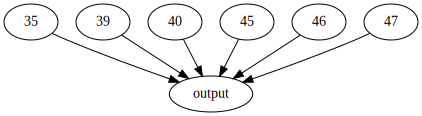

saved to checkpoint ckpts/2024-03-27_20-22-36/checkpoint 0.pkl
patching 43 edges, keeping 6 edges, 1176 remain
patching 43 edges, keeping 6 edges, 1176 remain
baseline score 0.9799999594688416
[48] sized edge sets remaining
got scores tensor([0.9200], device='cuda:0')
splitting 48 edges into two edge sets, as they have score 0.9199999570846558 which has diff 0.06000000238418579 > 1e-05
patching 43 edges, keeping 6 edges, 1176 remain
baseline score 0.9799999594688416
[24, 24] sized edge sets remaining
got scores tensor([0.9800, 0.9200], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 0.9199999570846558 which has diff 0.06000000238418579 > 1e-05
doing rollback test with score 0.9799999594688416 and score_lost_by_edge_set 0.0 with edge set of size 24
rolling back with pivot 1
patching 24 edges with score 0.9799999594688416 with diff of 0.0
but patching with others at the same time, overall they have score 0.9799999594688416 with diff of 0.0
patching 67 edges, ke

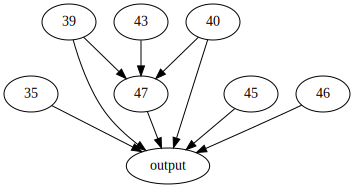

saved to checkpoint ckpts/2024-03-27_20-22-36/checkpoint 1.pkl
patching 88 edges, keeping 9 edges, 1128 remain
patching 88 edges, keeping 9 edges, 1128 remain
baseline score 0.9799999594688416
[47] sized edge sets remaining
got scores tensor([0.9700], device='cuda:0')
splitting 47 edges into two edge sets, as they have score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
patching 88 edges, keeping 9 edges, 1128 remain
baseline score 0.9799999594688416
[23, 24] sized edge sets remaining
got scores tensor([0.9800, 0.9700], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
doing rollback test with score 0.9799999594688416 and score_lost_by_edge_set 0.0 with edge set of size 23
rolling back with pivot 1
patching 23 edges with score 0.9799999594688416 with diff of 0.0
but patching with others at the same time, overall they have score 0.9799999594688416 with diff of 0.0
patching 111 edges,

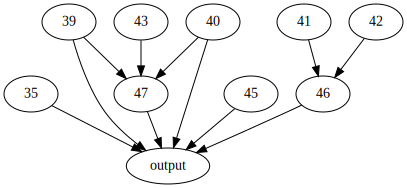

saved to checkpoint ckpts/2024-03-27_20-22-36/checkpoint 2.pkl
patching 133 edges, keeping 11 edges, 1081 remain
patching 133 edges, keeping 11 edges, 1081 remain
baseline score 0.9799999594688416
[46] sized edge sets remaining
got scores tensor([0.9600], device='cuda:0')
splitting 46 edges into two edge sets, as they have score 0.9599999785423279 which has diff 0.019999980926513672 > 1e-05
patching 133 edges, keeping 11 edges, 1081 remain
baseline score 0.9799999594688416
[23, 23] sized edge sets remaining
got scores tensor([0.9800, 0.9600], device='cuda:0')
splitting 23 edges into two edge sets, as they have score 0.9599999785423279 which has diff 0.019999980926513672 > 1e-05
doing rollback test with score 0.9799999594688416 and score_lost_by_edge_set 0.0 with edge set of size 23
rolling back with pivot 1
patching 23 edges with score 0.9799999594688416 with diff of 0.0
but patching with others at the same time, overall they have score 0.9799999594688416 with diff of 0.0
patching 156 

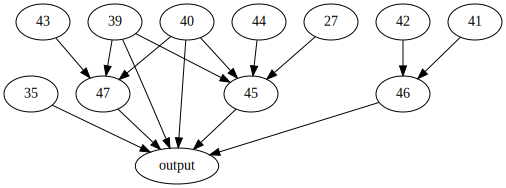

saved to checkpoint ckpts/2024-03-27_20-22-36/checkpoint 3.pkl
patching 175 edges, keeping 15 edges, 1035 remain
patching 175 edges, keeping 15 edges, 1035 remain
baseline score 0.9799999594688416
[45] sized edge sets remaining
got scores tensor([0.9700], device='cuda:0')
splitting 45 edges into two edge sets, as they have score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
patching 175 edges, keeping 15 edges, 1035 remain
baseline score 0.9799999594688416
[22, 23] sized edge sets remaining
got scores tensor([0.9800, 0.9700], device='cuda:0')
splitting 23 edges into two edge sets, as they have score 0.9699999690055847 which has diff 0.009999990463256836 > 1e-05
doing rollback test with score 0.9799999594688416 and score_lost_by_edge_set 0.0 with edge set of size 22
rolling back with pivot 1
patching 22 edges with score 0.9799999594688416 with diff of 0.0
but patching with others at the same time, overall they have score 0.9799999594688416 with diff of 0.0
patching 197 

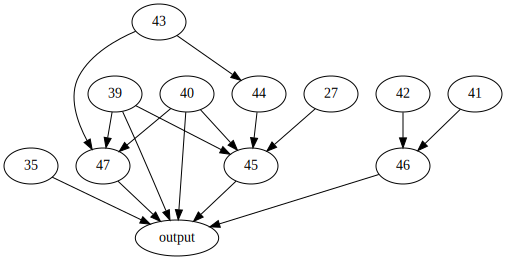

saved to checkpoint ckpts/2024-03-27_20-22-36/checkpoint 4.pkl
patching 219 edges, keeping 16 edges, 990 remain
patching 219 edges, keeping 16 edges, 990 remain
baseline score 0.9799999594688416
[44] sized edge sets remaining
got scores tensor([0.9600], device='cuda:0')
splitting 44 edges into two edge sets, as they have score 0.9599999785423279 which has diff 0.019999980926513672 > 1e-05
patching 219 edges, keeping 16 edges, 990 remain
baseline score 0.9799999594688416
[22, 22] sized edge sets remaining


In [ ]:
from transformer_lens.hook_points import HookPoint
from acdc import Edge, ACDCConfig, LOG_LEVEL_INFO, LOG_LEVEL_DEBUG, run_acdc

global storage
storage = {}
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    return x

layers = list(range(model.cfg.n_layers))

## Setup edges for ACDC
edges = []

B,L = data.data.size()

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'input'

last_layer = max(layers)
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def layer_node(layer):
    return f'{layer}'

# direct connection from embed to output
edges.append(Edge(
        input_node=INPUT_NODE,
        input_hook=(INPUT_HOOK, storage_hook),
        output_node=OUTPUT_NODE,
        output_hook=(OUTPUT_HOOK, resid_patching_hook),
))

for layer in layers:
    # edge from embed to layer input
    edges.append(Edge(
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=layer_node(layer),
            output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
    ))

    # edge from some other earlier layer to this layer
    for other_layer in layers:
        if other_layer < layer:
            edges.append(Edge(
                    input_node=layer_node(other_layer),
                    input_hook=(f'blocks.{other_layer}.hook_out_proj', storage_hook),
                    output_node=layer_node(layer),
                    output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
            ))

    # edge from layer output to final layer output
    edges.append(Edge(
            input_node=layer_node(layer),
            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, resid_patching_hook),
    ))

model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True,
}

cfg = ACDCConfig(
    thresh = 0.00001,
    rollback_thresh = 0.00001,
    metric=accuracy_metric,
    model_kwargs=model_kwargs,
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    auto_hide_unused_default_edges=True,
    batch_size=3,
    log_level=LOG_LEVEL_INFO,
    batched = True,
    recursive = True,
    try_patching_multiple_at_same_time = True,
)

result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)


